<a href="https://colab.research.google.com/github/Prajwal-Katuwal/Worksheet_AI/blob/main/2548856_PrajwalKatuwal_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset: Global Health,Mortality & Disease Trend Since 2000**


**Task: To predict infant mortality rate using historical data over time.**


**UNSDG: SDG 3: Good Health and Wealth being.**

Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


**Exploratory Data Analysis and Data Understanding**

1.Choosing and loading dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data.csv')

**DATASET DESCRIPTION**

(a) When and by whom the dataset was created.

**->This dataset was created in 2023 by WHO and World Bank**


(b) How and from where the dataset was accessed.

**->This dataset is accessed from Kaggle by downloading the compiled CSV file uploaded in the website.**

(c) How it aligns with the chosen UNSDG.

**-> It aligns with the chose UNSDG, SDG 3: Good health and wealth being, as it measures all the rates(infant mortality rate for now) which is used to assess child health outcomes, health care access and all quality of life factors.**


(d) Attributes (Columns) and Descriptions


**Country Name->	Name of the country where the indicator is measured**

**Series Name -> 	Name of the development indicator (e.g., Infant mortality rate)**

**2000–2023 -> 	Annual numeric values of the selected indicator for each year**

Questions that this dataset could answer:

**How has infant mortality rate changed globally from 2000 to 2023?**

**Can infant mortality rates be predicted based on historical trends using regression models?**

**Do different countries exhibit varying rates of improvement in infant mortality over time?**

• Assess the dataset’s suitability (completeness, relevance, quality, etc.)

**Completeness-> The dataset provides long-term annual data across many countries; however, some countries contain missing values for certain years, which are addressed during data preprocessing.**

**Relevance-> Infant mortality rate is directly linked to public health outcomes and is a widely accepted indicator for evaluating healthcare effectiveness and development progress.**

**Quality-> As the data is sourced from the World Bank, it is standardized, credible, and suitable for academic analysis. The continuous numeric nature of the indicator makes it highly appropriate for regression modeling.**

2. Exploratory Data Analysis and Data Cleaning

a. Data Reshaping

In [ ]:
# Find series names related to infant mortality
series_matches = df[
    df["Series Name"].str.lower().str.contains("infant", na=False) &
    df["Series Name"].str.lower().str.contains("mort", na=False)
]["Series Name"].unique()

series_matches


array(['Mortality rate, infant (per 1,000 live births)',
       'Mortality rate, infant, female (per 1,000 live births)',
       'Mortality rate, infant, male (per 1,000 live births)'],
      dtype=object)

In [ ]:
chosen_series = series_matches[0]  # change index if needed
print("Using series:", chosen_series)

df_inf = df[df["Series Name"] == chosen_series].copy()
df_inf.head()


Using series: Mortality rate, infant (per 1,000 live births)


,Series Name,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
11284,"Mortality rate, infant (per 1,000 live births)",Afghanistan,110.1,107,103.8,100.6,97.2,93.7,90.1,86.7,...,66.4,64.2,62.3,60.4,58.6,56.9,55.3,53.6,52,50.4
11285,"Mortality rate, infant (per 1,000 live births)",Albania,17.9,17,16.1,15.3,14.4,13.5,12.7,11.9,...,7.8,7.6,7.6,7.7,7.8,8,8.1,8.2,8.3,8.3
11286,"Mortality rate, infant (per 1,000 live births)",Algeria,34.7,33.6,32.4,31.3,30.1,29,27.9,26.9,...,22.3,21.9,21.6,21.3,21,20.7,20.4,20.2,20,19.7
11287,"Mortality rate, infant (per 1,000 live births)",American Samoa,,,,,,,,,...,,,,,,,,,,
11288,"Mortality rate, infant (per 1,000 live births)",Andorra,6.6,6.3,6.1,5.8,5.6,5.4,5.1,4.9,...,3.5,3.4,3.2,3.1,2.9,2.8,2.7,2.7,2.6,2.5


In [ ]:
# Identify year columns
year_cols = [c for c in df_inf.columns if c.isdigit()]
year_cols = sorted(year_cols, key=lambda x: int(x))

# Convert wide -> long
long_df = df_inf.melt(
    id_vars=["Country Name", "Series Name"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Infant_Mortality"
)

# Convert to numeric
long_df["Year"] = pd.to_numeric(long_df["Year"], errors="coerce")
long_df["Infant_Mortality"] = pd.to_numeric(long_df["Infant_Mortality"], errors="coerce")

# Drop missing values
long_df = long_df.dropna(subset=["Infant_Mortality"]).reset_index(drop=True)

long_df.head()


,Country Name,Series Name,Year,Infant_Mortality
0,Afghanistan,"Mortality rate, infant (per 1,000 live births)",2000,110.1
1,Albania,"Mortality rate, infant (per 1,000 live births)",2000,17.9
2,Algeria,"Mortality rate, infant (per 1,000 live births)",2000,34.7
3,Andorra,"Mortality rate, infant (per 1,000 live births)",2000,6.6
4,Angola,"Mortality rate, infant (per 1,000 live births)",2000,115.0


In [ ]:
# Missing values
long_df.isna().sum()
# Ensure correct data types
long_df["Year"] = long_df["Year"].astype(int)
long_df["Infant_Mortality"] = long_df["Infant_Mortality"].astype(float)



In [ ]:
# Outlier check (IQR method)
Q1 = long_df["Infant_Mortality"].quantile(0.25)
Q3 = long_df["Infant_Mortality"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = long_df[
    (long_df["Infant_Mortality"] < lower) |
    (long_df["Infant_Mortality"] > upper)
]

outliers.shape


(108, 4)

In [ ]:
long_df["Infant_Mortality"].describe()



,Infant_Mortality
count,4704.000000
mean,26.651212
std,25.264045
min,1.400000
25%,7.000000
50%,17.100000
75%,40.300000
max,234.900000


**a. Trend of mortality rate overtime**

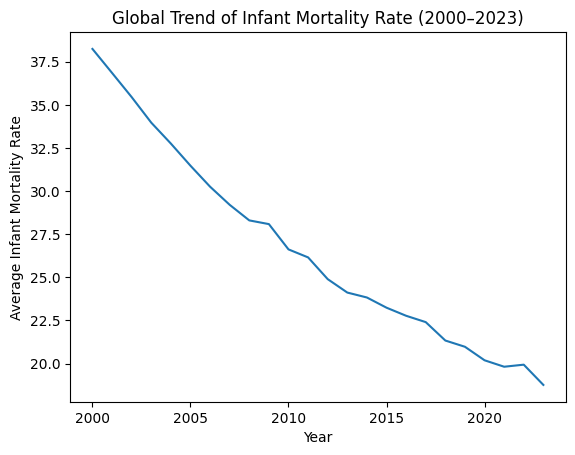

In [ ]:
yearly_avg = long_df.groupby("Year")["Infant_Mortality"].mean()

plt.figure()
plt.plot(yearly_avg.index, yearly_avg.values)
plt.xlabel("Year")
plt.ylabel("Average Infant Mortality Rate")
plt.title("Global Trend of Infant Mortality Rate (2000–2023)")
plt.show()


**b. Distribution of infant mortality rate**

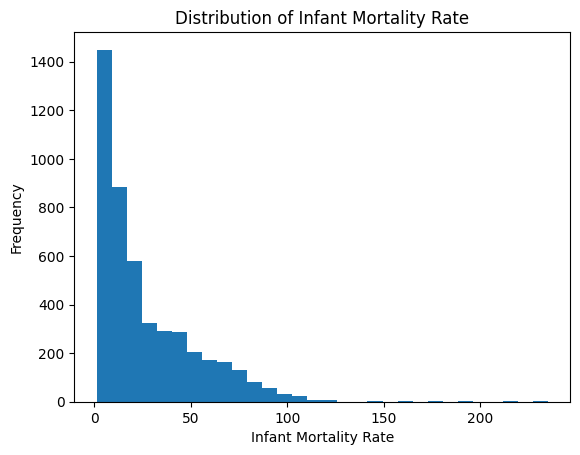

In [ ]:
plt.figure()
plt.hist(long_df["Infant_Mortality"], bins=30)
plt.xlabel("Infant Mortality Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Infant Mortality Rate")
plt.show()


**c. Box Plot of infant mortality rate**

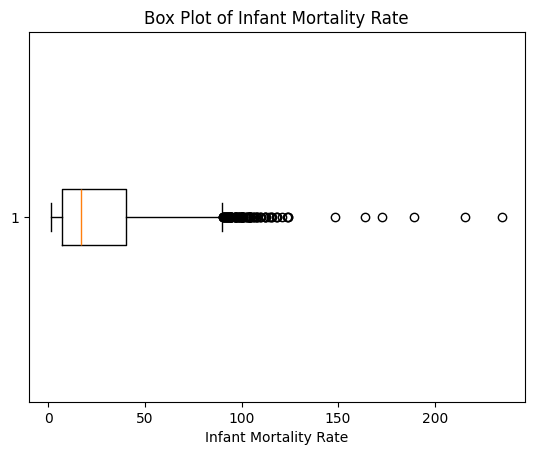

In [ ]:
plt.figure()
plt.boxplot(long_df["Infant_Mortality"], vert=False)
plt.xlabel("Infant Mortality Rate")
plt.title("Box Plot of Infant Mortality Rate")
plt.show()


**2. Building a Neural Network Model for Regression**

Preparing X and Y and splitting training & testing data.

In [ ]:
# Features and target
X = long_df[["Year"]].copy()
y = long_df["Infant_Mortality"].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((3763, 1), (941, 1))

Scaling the input

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Building the Neural Network(MLP)

In [ ]:
model = Sequential([
    Dense(16, activation="relu", input_shape=(1,)),
    Dense(8, activation="relu"),
    Dense(1)  # linear output for regression
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="mse"
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177 (708.00 B)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

Training the model

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    verbose=1
)


Epoch 1/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1060.6868 - val_loss: 598.9427
Epoch 2/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 689.5353 - val_loss: 596.3043
Epoch 3/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 577.7372 - val_loss: 596.1764
Epoch 4/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 607.4495 - val_loss: 595.7090
Epoch 5/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 595.0097 - val_loss: 595.4258
Epoch 6/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 599.0700 - val_loss: 595.8402
Epoch 7/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 639.3693 - val_loss: 597.4756
Epoch 8/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 626.8716 - val_loss: 598.4958
Epoch 9/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 604.8838 - val_loss: 595.5385
Epoch 10/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 592.3984 - val_loss: 594.9280
Epoch 11/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 609.5272 - val_loss: 599.2216
Epoch 12/80
95/95 ━━━━━━━━━━━

Evaluating on Training and Testing data

In [ ]:
# Predictions
y_train_pred = model.predict(X_train_scaled).flatten()
y_test_pred = model.predict(X_test_scaled).flatten()

# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("TRAIN -> MSE:", train_mse, "RMSE:", train_rmse, "R2:", train_r2)
print("TEST  -> MSE:", test_mse,  "RMSE:", test_rmse,  "R2:", test_r2)


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
TRAIN -> MSE: 605.7890854968354 RMSE: 24.61278296936036 R2: 0.05056834466843252
TEST  -> MSE: 612.1852518732926 RMSE: 24.742377651981883 R2: 0.04048853472026359


Predicted VS Actual value

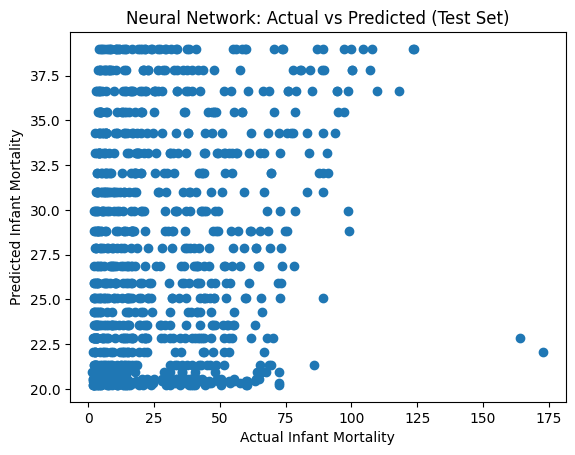

In [ ]:
plt.figure()
plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual Infant Mortality")
plt.ylabel("Predicted Infant Mortality")
plt.title("Neural Network: Actual vs Predicted (Test Set)")
plt.show()


**3. Building primary machine learning models**

Splitting data into training and testing

In [ ]:
X = long_df[["Year"]]
y = long_df["Infant_Mortality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Linear Regression(Model 1)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

# Metrics
lr_train_mse = mean_squared_error(y_train, y_train_pred_lr)
lr_test_mse = mean_squared_error(y_test, y_test_pred_lr)

lr_train_rmse = np.sqrt(lr_train_mse)
lr_test_rmse = np.sqrt(lr_test_mse)

lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)

print("Linear Regression:")
print("Train -> RMSE:", lr_train_rmse, "R2:", lr_train_r2, "MAE:", lr_train_mae)
print("Test  -> RMSE:", lr_test_rmse,  "R2:", lr_test_r2,  "MAE:", lr_test_mae)


Linear Regression:
Train -> RMSE: 24.607800375050367 R2: 0.05095271029961701 MAE: 19.597589184126484
Test  -> RMSE: 24.764287878543062 R2: 0.03878842147865791 MAE: 19.808184220280562


Decision Tree(Model 2)

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

# Metrics
dt_train_mse = mean_squared_error(y_train, y_train_pred_dt)
dt_test_mse = mean_squared_error(y_test, y_test_pred_dt)

dt_train_rmse = np.sqrt(dt_train_mse)
dt_test_rmse = np.sqrt(dt_test_mse)

dt_train_r2 = r2_score(y_train, y_train_pred_dt)
dt_test_r2 = r2_score(y_test, y_test_pred_dt)

dt_train_mae = mean_absolute_error(y_train, y_train_pred_dt)
dt_test_mae = mean_absolute_error(y_test, y_test_pred_dt)

print("\nDecision Tree Regressor:")
print("Train -> RMSE:", dt_train_rmse, "R2:", dt_train_r2, "MAE:", dt_train_mae)
print("Test  -> RMSE:", dt_test_rmse,  "R2:", dt_test_r2,  "MAE:", dt_test_mae)



Decision Tree Regressor:
Train -> RMSE: 24.584709189357586 R2: 0.05273298686765626 MAE: 19.571497442411637
Test  -> RMSE: 24.774882895527643 R2: 0.037965766565677295 MAE: 19.85516180577296


Comparison and deciding which model is better

Linear Regression and Decision Tree Regressor were evaluated using RMSE, MAE, and R² metrics and showed very similar performance, with test RMSE values around 25 and R² values close to 0.04. Linear Regression demonstrated slightly better generalization on the test set, while the Decision Tree achieved marginally higher performance on the training data without improving test results.

 **Overall, Linear Regression was selected as the better model due to its simplicity, stability, and marginally lower test error.**

4. Hyperparameter Optimization with cross-validation

In [ ]:
scoring = "neg_root_mean_squared_error"

 #Linear Regression Grid
lr = LinearRegression()

lr_param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False]
}

lr_grid = GridSearchCV(
    estimator=lr,
    param_grid=lr_param_grid,
    scoring=scoring,
    cv=5,
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)

print("Linear Regression best params:", lr_grid.best_params_)
print("Linear Regression best CV RMSE:", -lr_grid.best_score_)


# B) Decision Tree Grid
dt = DecisionTreeRegressor(random_state=42)

dt_param_grid = {
    "max_depth": [2, 3, 4, 5, 8, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": [None, "sqrt", "log2"]
}

dt_grid = GridSearchCV(
    estimator=dt,
    param_grid=dt_param_grid,
    scoring=scoring,
    cv=5,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

print("\nDecision Tree best params:", dt_grid.best_params_)
print("Decision Tree best CV RMSE:", -dt_grid.best_score_)


Linear Regression best params: {'fit_intercept': True, 'positive': False}
Linear Regression best CV RMSE: 24.612774384333548

Decision Tree best params: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree best CV RMSE: 24.7020816421578


**5. Feature Selection**

In [ ]:
# SelectKBest for Linear Regression (feature selection step)
fs_lr = SelectKBest(score_func=f_regression, k=1)
fs_lr.fit(X_train, y_train)

print("Selected feature (LR):", X_train.columns[fs_lr.get_support()])
print("F-score:", fs_lr.scores_, "p-value:", fs_lr.pvalues_)


Selected feature (LR): Index(['Year'], dtype='object')
F-score: [201.92159603] p-value: [1.11778999e-44]


In [ ]:
# Same feature selection for Decision Tree too
fs_dt = SelectKBest(score_func=f_regression, k=1)
fs_dt.fit(X_train, y_train)

print("Selected feature (DT):", X_train.columns[fs_dt.get_support()])


Selected feature (DT): Index(['Year'], dtype='object')


Justification for chosen feature and methods

SelectKBest with f_regression was used as the feature selection method, as it is suitable for regression tasks and effective for small feature sets. **It was also used as there was only one feature(i.e. Year),** thus unable to use RFE as it requires 2 or more features to compare. The method selected Year for both models, supported by a high F-score and a very low p-value, confirming its relevance in predicting infant mortality rates.

**6. Final Models and comparative Analysis**

Rebuilding both models

Final Linear Regression.

In [ ]:
final_lr = LinearRegression(
    fit_intercept=True,
    positive=False
)

final_lr.fit(X_train, y_train)
y_test_pred_lr = final_lr.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_r2 = r2_score(y_test, y_test_pred_lr)


Final Decision Tree

In [ ]:
final_dt = DecisionTreeRegressor(
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    random_state=42
)

final_dt.fit(X_train, y_train)
y_test_pred_dt = final_dt.predict(X_test)

dt_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
dt_mae = mean_absolute_error(y_test, y_test_pred_dt)
dt_r2 = r2_score(y_test, y_test_pred_dt)


FINAL COMPARISION TABLE

In [ ]:
final_comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree Regressor"],
    "Features Used": ["Year", "Year"],
    "CV RMSE": [24.61, 24.70],
    "Test RMSE": [lr_rmse, dt_rmse],
    "Test R-squared": [lr_r2, dt_r2]
})

final_comparison


,Model,Features Used,CV RMSE,Test RMSE,Test R-squared
0,Linear Regression,Year,24.61,24.764288,0.038788
1,Decision Tree Regressor,Year,24.70,24.783215,0.037319


Graph for Actual VS Predicted(Linear Regression)

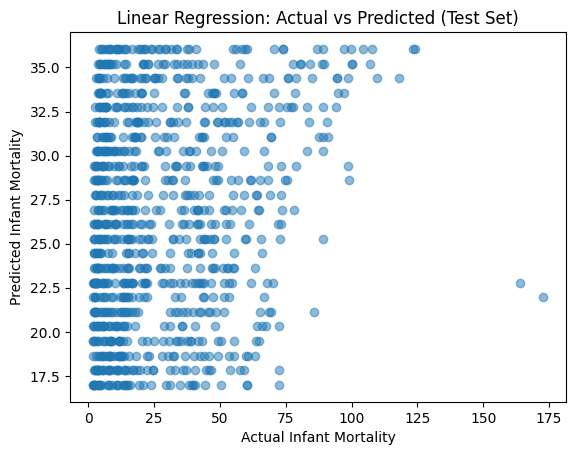

In [ ]:
plt.figure()
plt.scatter(y_test, y_test_pred_lr, alpha=0.5)
plt.xlabel("Actual Infant Mortality")
plt.ylabel("Predicted Infant Mortality")
plt.title("Linear Regression: Actual vs Predicted (Test Set)")
plt.show()


The scatter plot shows the relationship between actual and predicted infant mortality values, indicating that the model captures the general trend but underestimates extreme values.

Regression line overtime

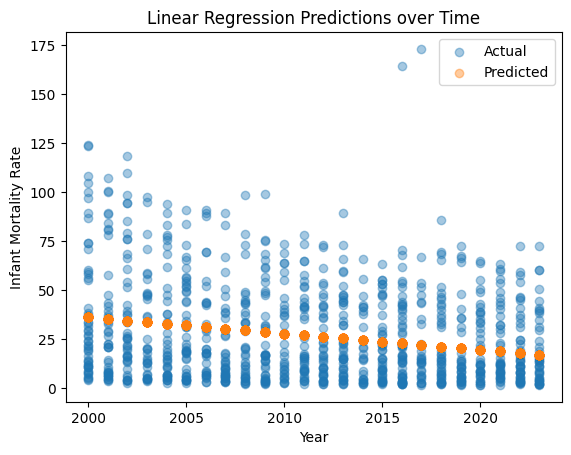

In [ ]:
plt.figure()
plt.scatter(X_test, y_test, alpha=0.4, label="Actual")
plt.scatter(X_test, y_test_pred_lr, alpha=0.4, label="Predicted")
plt.xlabel("Year")
plt.ylabel("Infant Mortality Rate")
plt.title("Linear Regression Predictions over Time")
plt.legend()
plt.show()


The plot illustrates how predicted infant mortality values follow the overall declining trend over time, although deviations remain for country-specific differences.

**7.Conclusion and Reflection**


1) Model Performance:
- Final models evaluated were Linear Regression and Decision Tree Regressor using Year as the selected feature.

- Test RMSE for both models was approximately 25, indicating moderate prediction error.

- Test R-squared values were low (~0.04), showing that Year alone explains a limited proportion of the variance in infant mortality.

- Linear Regression performed marginally better than Decision Tree Regressor in terms of test RMSE and generalization stability.



2) Impact of Methods (Cross-Validation + Feature Selection):
- Cross-validation (GridSearchCV) helped identify optimal hyperparameters and ensured fair model comparison without overfitting.


- Feature selection using SelectKBest with f_regression confirmed that Year is a statistically significant predictor of infant mortality.


- Using a single selected feature reduced model complexity and improved interpretability, though it also limited predictive power.



3) Insights and Future Directions:


- Infant mortality is influenced by multiple socio-economic and healthcare factors that were not available in the dataset.


- Future work could include additional indicators such as income, education, healthcare access, or country-level development metrics.


- Time-aware validation strategies (training on earlier years and testing on later years) could better capture temporal dynamics.


- More advanced models such as Gradient Boosting or multivariate regression could be explored to improve predictive performance.
